# 4 Fitting Circles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = np.load("circles.npy")
X_coord = data.T[0]
Y_coord = data.T[1]

(0, 1)

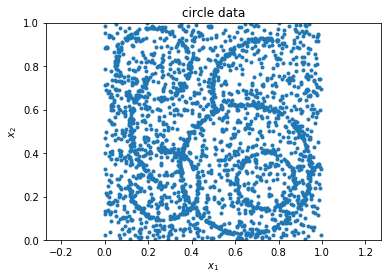

In [3]:
plt.scatter(X_coord,Y_coord, marker = ".")
plt.axis('equal')
plt.title('circle data')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.ylim((0,1))
plt.xlim((0,1))

By just counting the obvious ones we would fit 6 circles.

## 4.1 RANSAC

In [4]:
#returns cx,cy,,r
def fitCircle(points):
    x1,y1,x2,y2,x3,y3=*points.flatten(),
    A=x1*(y2-y3)-y1*(x2-x3)+x2*y3-x3*y2
    B=(x1**2+y1**2)*(y3-y2)+(x2**2+y2**2)*(y1-y3)+(x3**2+y3**2)*(y2-y1)
    C=(x1**2+y1**2)*(x2-x3)+(x2**2+y2**2)*(x3-x1)+(x3**2+y3**2)*(x1-x2)
    cx=-B/(2*A)
    cy=-C/(2*A)
    r=np.sqrt((x1-cx)**2+(y1-cy)**2)
    return cx,cy,r

In [20]:
def RANSAC_Circle(data,N,epsilon,return_inliers=False):
    bestCircle,inliers=None,[]
    for i in range(N):
        #choose randomly 3 points
        points=data[np.random.permutation(len(data))][:3]
        #get parameters of circle
        cx,cy,r=fitCircle(points)
        #calculate distance to circle for all points
        distances=np.abs(np.sqrt(np.sum(np.square(data-np.array([cx,cy])),axis=1))-r)
        inl=np.argwhere(distances<epsilon)
        #added '/r' to not prioritize big circles with few points over smaller ones with many points
        if len(inl)/r>len(inliers)/r:
            inliers=inl
            bestCircle=[cx,cy,r]
    if return_inliers:
        return bestCircle,inliers 
    else:
        return bestCircle

In [21]:
def multipleCircles(data,N,epsilon,circleNumber):
    circles=[]
    dataPoints=data.copy()
    for i in range(circleNumber):
        circle_i,inliers=RANSAC_Circle(dataPoints,N,epsilon,return_inliers=True)
        dataPoints=np.delete(dataPoints,inliers,0).reshape(-1,2)
        circles.append(circle_i)
    return circles

In [28]:
circles=multipleCircles(data,6000,.0055,6) #before epsilon=.0048

(0, 1)

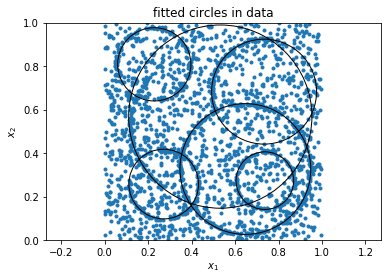

In [29]:
plt.scatter(X_coord,Y_coord, marker = ".")
for c in circles:
    ci=plt.Circle((c[0],c[1]),radius=c[2],fill=False)
    plt.gca().add_patch(ci)
plt.axis('equal')
plt.title('fitted circles in data')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.ylim((0,1))
plt.xlim((0,1))

The choice of $\epsilon$ was the hardest part. Even a small change in value lead to different solutions: If $\epsilon$ was too big the RANSAC algorithm often fitted the noise. If it was too small it would fit a circle twice.

# 4.2 Algebraic distance

In [45]:
#from the lecture since alg_data doesn't work
def generic_data(data):
    Y = np.sum(np.square(data),axis = 1)
    #X = np.square(data).T
    X = np.array([])
    for i in range (2):
        X = np.append(X, data.T[i]).reshape(-1,len(data))
    #X = np.append(X, np.multiply(data.T[0], data.T[1])).reshape(-1,len(data))
    X = np.insert(X.T, len(X.T[0]), 1, axis = 1)
    return X,Y

In [52]:
def get_circle(beta):
    c1 = beta[0]/2
    c2 = beta[1]/2
    r = np.sqrt(beta[2] + c1**2 + c2**2)
    return c1,c2,r

In [55]:
c=get_circle(np.linalg.lstsq(*generic_data(data))[0])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [57]:
def multipleCirclesAlgFit(data,N,epsilon,circleNumber):
    circles=[]
    dataPoints=data.copy()
    for i in range(circleNumber):
        circle_i,inliers=RANSAC_Circle(dataPoints,N,epsilon,return_inliers=True)
        circles.append(get_circle(np.linalg.lstsq(*generic_data(dataPoints[inliers]))[0]))
        dataPoints=np.delete(dataPoints,inliers,0).reshape(-1,2)

    return circles

In [58]:
circlesAlg=multipleCircles(data,6000,.0055,6) #before epsilon=.0048

(0, 1)

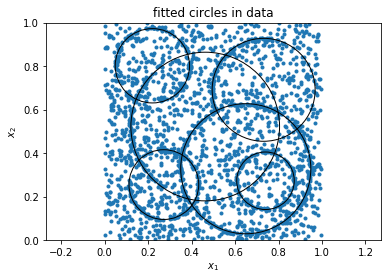

In [59]:
plt.scatter(X_coord,Y_coord, marker = ".")
for c in circlesAlg:
    ci=plt.Circle((c[0],c[1]),radius=c[2],fill=False)
    plt.gca().add_patch(ci)
plt.axis('equal')
plt.title('fitted circles in data')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.ylim((0,1))
plt.xlim((0,1))

The circles are better fitted than before.